# Analysis of Barrier Algorithms Benchmarking

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [45]:
barrier_tree = pd.read_csv('barrier_tree.csv')
barrier_linear = pd.read_csv('barrier_linear.csv')
barrier_default = pd.read_csv('barrier_default.csv')
barrier_recursive_doubling = pd.read_csv('barrier_recursive_doubling.csv')

# doublering is not efficient in an case, so we remove it
# both linear and doublering require P communication stepes, but linear is more efficient
# linear is interesting because it scales linearly with the number of cores

# bruck and recursive doubling are similar, in fact they both require log(P) steps
# recursive doubling is more interesting because latency is reduced when the number of processes is a power of 2

# Define the list of algorithms and their corresponding DataFrames
algorithms = ['Linear', 'Default', 'Tree', 'Recursive Doubling']
dfs = [barrier_linear, barrier_default, barrier_tree, barrier_recursive_doubling]
allocations = ['core', 'socket', 'node']

In [46]:
def plot_latency_vs_processes(algorithms, dfs, allocation):
    # Iterate over each algorithm's DataFrame
    for algorithm, df in zip(algorithms, dfs):
        # Filter DataFrame based on allocation only
        df_filtered = df[df['Allocation'] == allocation]
        
        # Plot number of processes vs. latency
        plt.plot(df_filtered['Processes'], df_filtered['Latency'], label=algorithm)

    # Set labels and title
    plt.xlabel('Number of Processes')
    plt.ylabel('Latency')
    plt.title(f'Latency vs. Num Processes (Map-by: {allocation.capitalize()})')
    plt.legend()
    plt.grid(True)

    # Add vertical lines at specific process counts
    for i in [12, 24, 36]:
        plt.axvline(x=i, linestyle='--', color='gray')

In [47]:
def plot_latency_vs_processes_fixed_alg(algorithm, df, allocations, power_of_two=False):
    # Iterate over each allocation strategy
    for allocation in allocations:
        # Filter DataFrame based on the specific algorithm and allocation
        df_filtered = df[(df['Algorithm'] == algorithm) & 
                         (df['Allocation'] == allocation)]
        
        # Plot number of processes vs. latency for this allocation
        plt.plot(df_filtered['Processes'], df_filtered['Latency'], label=f'{allocation.capitalize()}')

    # Set labels and title
    plt.xlabel('Number of Processes')
    plt.ylabel('Latency (us)')
    plt.title(f'Latency vs. Num Processes for Alg: {algorithm}')
    plt.legend()
    plt.grid(True)

    # Add vertical lines at specific process counts
    if power_of_two:
        for i in [4, 8, 16, 32]:
            plt.axvline(x=i, linestyle='--', color='gray')
    else:
        for i in [12, 24, 36]:
            plt.axvline(x=i, linestyle='--', color='gray')

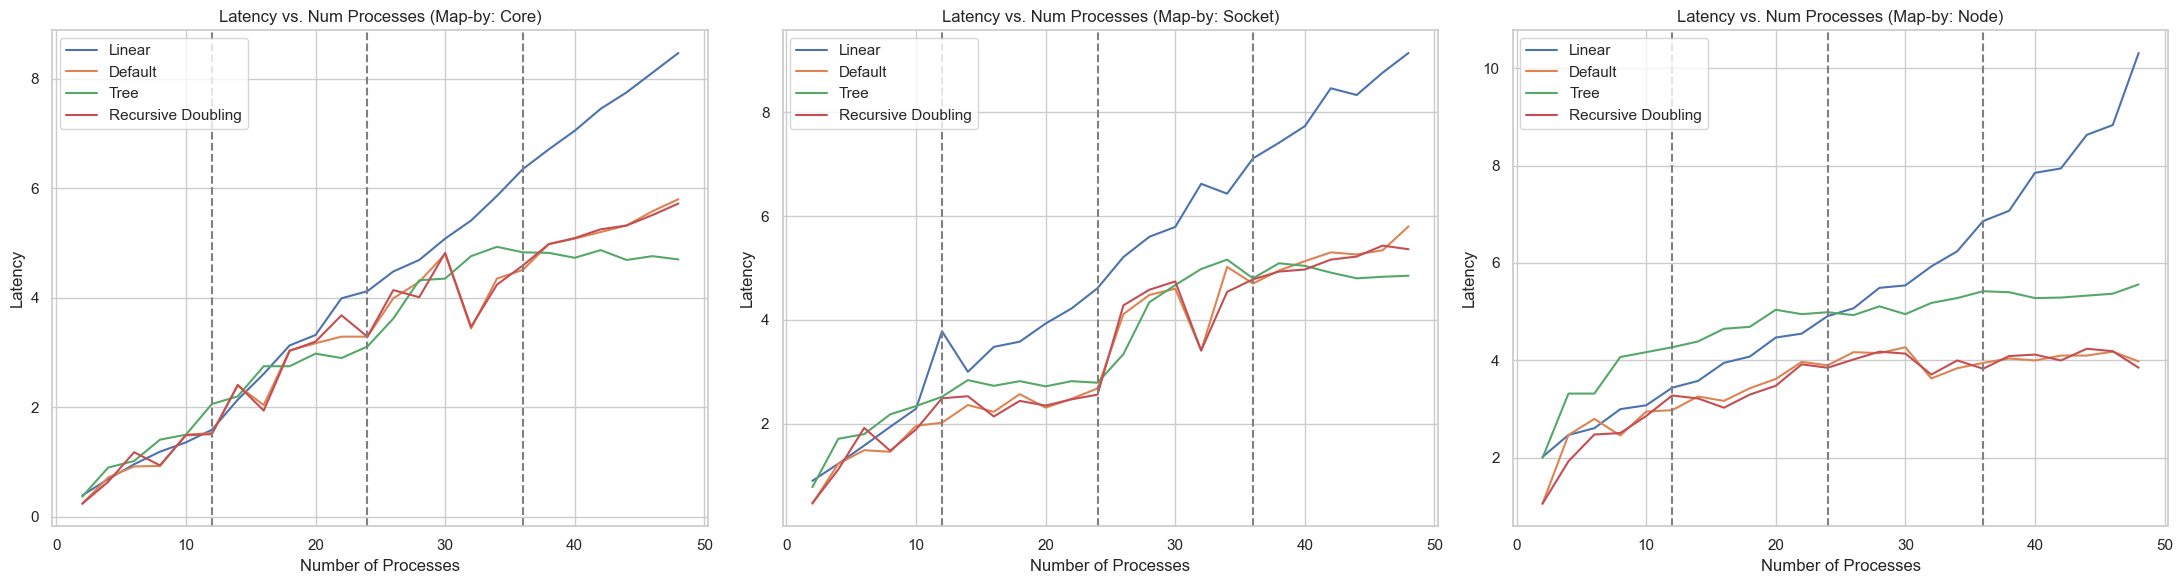

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(22, 6))
plt.sca(axs[0])
plot_latency_vs_processes(algorithms, dfs, 'core')
plt.sca(axs[1])
plot_latency_vs_processes(algorithms, dfs, 'socket')
plt.sca(axs[2])
plot_latency_vs_processes(algorithms, dfs, 'node')
plt.tight_layout()
plt.savefig('figures/latency_vs_processes.png')
plt.show()

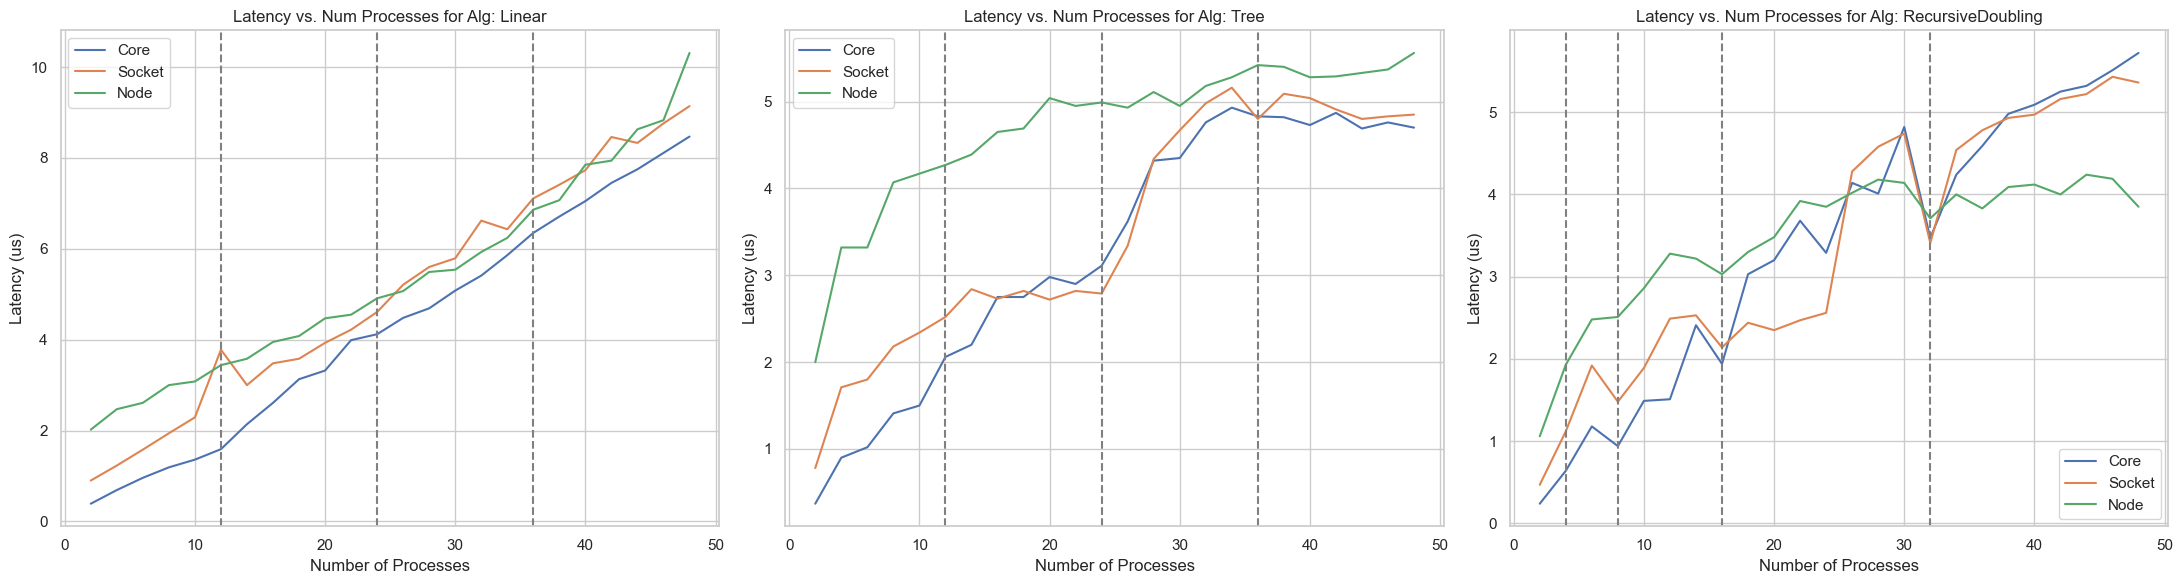

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(22, 6))
plt.sca(axs[0])
plot_latency_vs_processes_fixed_alg('Linear', barrier_linear, allocations, False)
plt.sca(axs[1])
plot_latency_vs_processes_fixed_alg('Tree', barrier_tree, allocations, False)
plt.sca(axs[2])
plot_latency_vs_processes_fixed_alg('RecursiveDoubling', barrier_recursive_doubling, allocations, True)
plt.tight_layout()
plt.savefig('figures/latency_fix_alg.png')
plt.show()

In [50]:
def plot_latency_diff_vs_processes(df_default, other_dfs, other_algorithm_names, allocation):
    # Filter the default algorithm DataFrame for the given allocation
    df_default_filtered = df_default[df_default['Allocation'] == allocation]

    # Concatenate other algorithm DataFrames and filter by allocation
    concatenated_df = pd.concat(other_dfs, ignore_index=True)
    filter_df = concatenated_df[concatenated_df['Allocation'] == allocation]

    # Get the minimum latency for each process count
    min_latencies = filter_df.loc[filter_df.groupby('Processes')['Latency'].idxmin()]

    # Merge the min latencies with the default latencies for comparison
    df_merged = pd.merge(df_default_filtered[['Processes', 'Latency']], 
                         min_latencies[['Processes', 'Latency', 'Algorithm']], 
                         on='Processes', suffixes=('_default', '_min'))

    # Initialize a colormap and markers for the other algorithms
    cmap = plt.get_cmap('tab10')  # Get the colormap
    colors = [cmap(i) for i in range(len(other_algorithm_names))]  # Get required number of colors

    # Initialize counters for differences
    positive_count = 0
    negative_count = 0
    zero_count = 0
    algorithms_plotted = set()  # Track algorithms that have been plotted

    # Iterate over each row in the merged DataFrame
    for _, row in df_merged.iterrows():
        default_latency = row['Latency_default']
        other_latency = row['Latency_min']
        latency_diff = default_latency - other_latency
        
        # Determine the algorithm name for coloring
        algorithm_name = min_latencies[min_latencies['Processes'] == row['Processes']]['Algorithm'].values[0]
        algorithm_index = other_algorithm_names.index(algorithm_name)

        # Plot a colored point if the difference is positive
        if latency_diff > 0:
            plt.scatter(row['Processes'], latency_diff, color=colors[algorithm_index], 
                        marker='o', label=algorithm_name if algorithm_name not in algorithms_plotted else "")
            algorithms_plotted.add(algorithm_name)  # Mark as plotted
            positive_count += 1  # Increment positive count
        # Plot a red "x" if the difference is negative
        elif latency_diff < 0:
            plt.scatter(row['Processes'], latency_diff, color='red', marker='x', s=100, label='_nolegend_')  # Red "x" for negative values
            negative_count += 1  # Increment negative count
        else:
            zero_count += 1  # Increment zero count

    # Set labels and title
    plt.xlabel('Number of Processes')
    plt.ylabel('Latency Difference (us)')
    plt.title(f'Latency Difference vs. Processes (Allocation: {allocation})')

    # Add vertical lines for specific process counts (optional)
    for i in [12, 24, 36]:
        plt.axvline(x=i, linestyle='--', color='gray')

    # Add a legend for the colored points in the bottom left
    plt.legend(title="Algorithms", loc="upper left")
    plt.grid(True)

    # Print counts of differences
    print(f'For {allocation} allocation:')
    print(f'Positive differences: {positive_count}')
    print(f'Negative differences: {negative_count}')
    print(f'Zero differences: {zero_count}')

For core allocation:
Positive differences: 19
Negative differences: 4
Zero differences: 1
For socket allocation:
Positive differences: 15
Negative differences: 8
Zero differences: 1
For node allocation:
Positive differences: 14
Negative differences: 9
Zero differences: 1


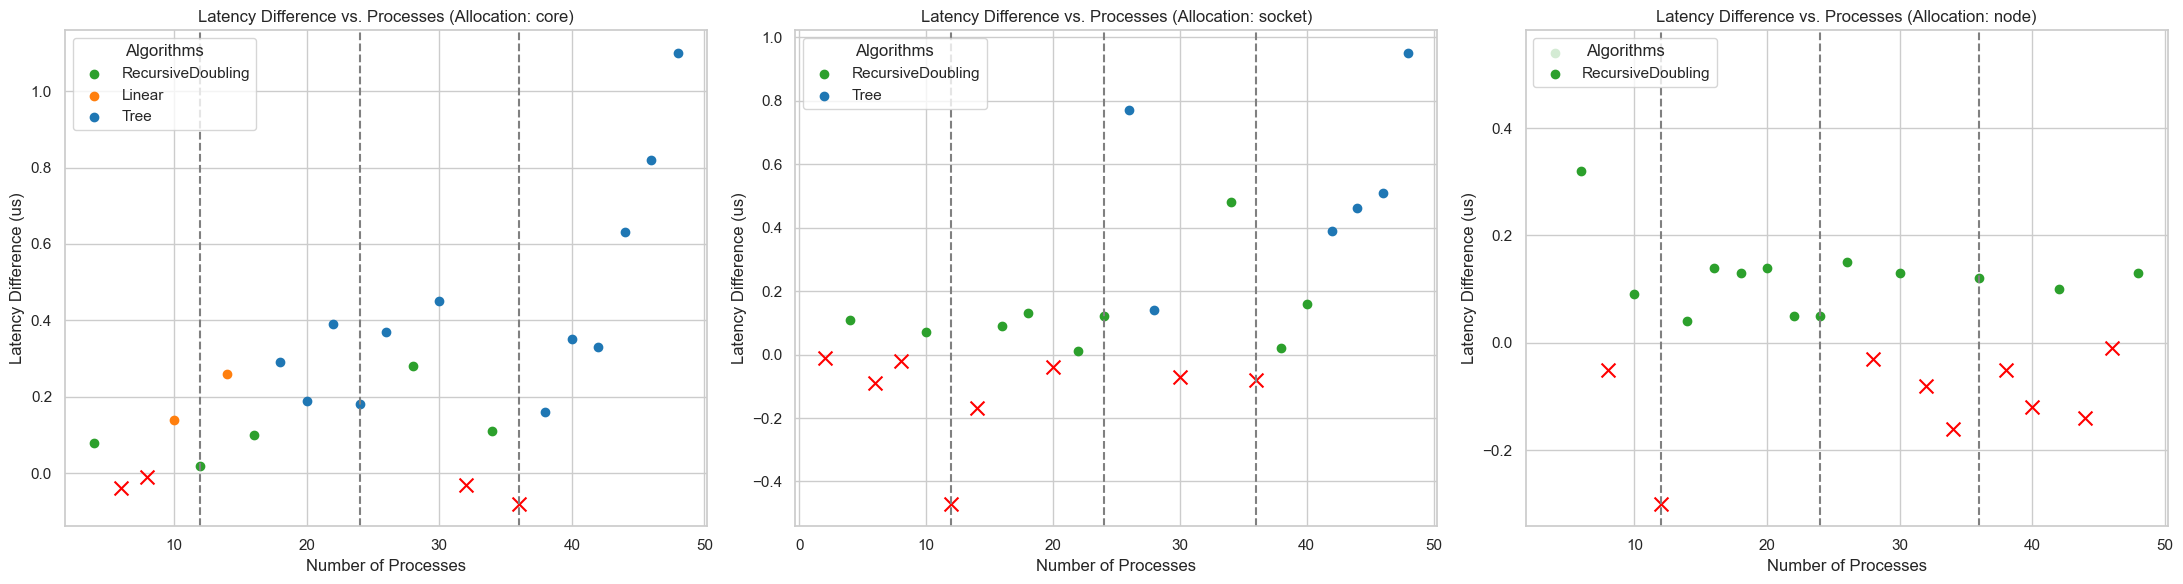

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(22, 6))
plt.sca(axs[0])
plot_latency_diff_vs_processes(barrier_default, [barrier_linear, barrier_tree, barrier_recursive_doubling], ['Tree', 'Linear', 'RecursiveDoubling'], 'core')
plt.sca(axs[1])
plot_latency_diff_vs_processes(barrier_default, [barrier_linear, barrier_tree, barrier_recursive_doubling], ['Tree', 'Linear', 'RecursiveDoubling'], 'socket')
plt.sca(axs[2])
plot_latency_diff_vs_processes(barrier_default, [barrier_linear, barrier_tree, barrier_recursive_doubling], ['Tree', 'Linear', 'RecursiveDoubling'], 'node')
plt.tight_layout()
plt.savefig('figures/latency_diff.png')
plt.show()

## Performance Model

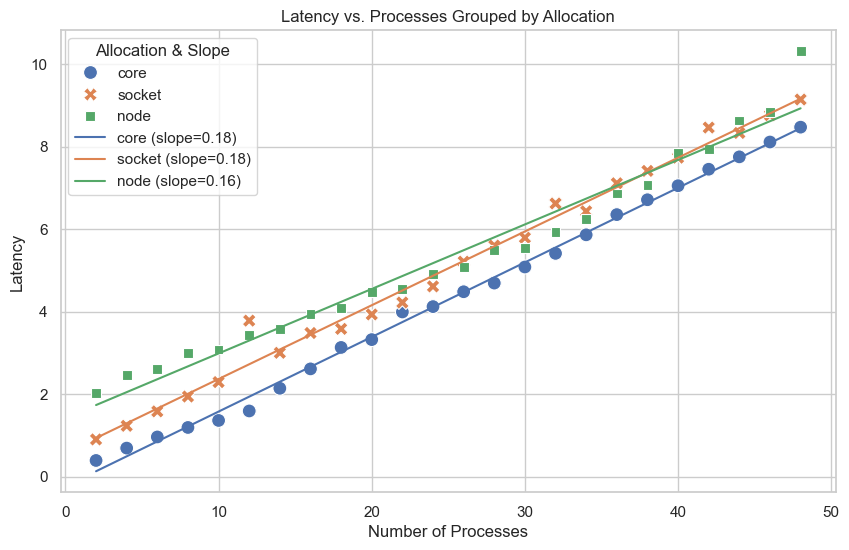

Allocation: core, Slope: 0.18, Intercept: -0.23
Allocation: socket, Slope: 0.18, Intercept: 0.58
Allocation: node, Slope: 0.16, Intercept: 1.42


In [65]:
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Example: barrier_linear = pd.DataFrame({'Allocation': [...], 'Processes': [...], 'Latency': [...]})
# Replace with your actual data
# barrier_linear = ...

# Initialize the plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot latency vs processes, grouped by allocation
sns.scatterplot(data=barrier_linear, x='Processes', y='Latency', hue='Allocation', style='Allocation', s=100)

# Prepare for regression analysis
allocations = barrier_linear['Allocation'].unique()

# Create a dictionary to store coefficients for each allocation
coefficients = {}

# Loop over each allocation group to fit and plot a regression line
for alloc in allocations:
    subset = barrier_linear[barrier_linear['Allocation'] == alloc]
    X = subset['Processes'].values.reshape(-1, 1)
    y = subset['Latency'].values
    
    # Perform linear regression
    model = LinearRegression()
    model.fit(X, y)
    
    # Store the coefficients
    coefficients[alloc] = {'slope': model.coef_[0], 'intercept': model.intercept_}
    
    # Generate regression line points
    X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred = model.predict(X_range)
    
    # Plot the regression line
    plt.plot(X_range, y_pred, label=f'{alloc} (slope={model.coef_[0]:.2f})')

# Set plot labels and title
plt.xlabel('Number of Processes')
plt.ylabel('Latency')
plt.title('Latency vs. Processes Grouped by Allocation')
plt.legend(title='Allocation & Slope')
plt.savefig('figures/latency_regression.png')
plt.show()

# Print the regression coefficients
for alloc, coef in coefficients.items():
    print(f"Allocation: {alloc}, Slope: {coef['slope']:.2f}, Intercept: {coef['intercept']:.2f}")

Allocation: core, Slopes between knots: [0.16028942476790156, 0.11359787992895849, 0.13827370467130096, -0.03553961941495731]
Allocation: socket, Slopes between knots: [0.15233774391563268, 0.0372925382909608, 0.18767052492778902, -0.05371815656116693]
Allocation: node, Slopes between knots: [0.20099861459841512, 0.0383752681129644, 0.02735026698750631, 0.011392189596293845]


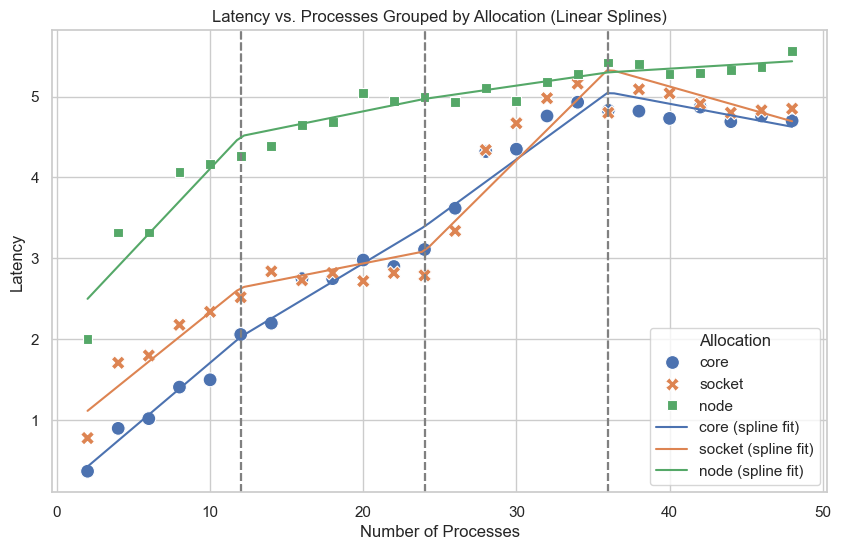

In [70]:
from scipy.interpolate import LSQUnivariateSpline

# Assuming barrier_tree DataFrame is already available
# Replace with actual data if necessary
# barrier_tree = pd.DataFrame({'Allocation': [...], 'Processes': [...], 'Latency': [...]})

# Initialize the plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot latency vs processes, grouped by allocation
sns.scatterplot(data=barrier_tree, x='Processes', y='Latency', hue='Allocation', style='Allocation', s=100)

# Prepare for spline fitting (degree 1 splines)
allocations = barrier_tree['Allocation'].unique()

# Create a dictionary to store coefficients for each allocation
splines_info = {}

splines_knots = {}
splines_knots['core'] = [12, 24, 36]
splines_knots['socket'] = [12, 24, 36]
splines_knots['node'] = [12, 24, 36]

# Loop over each allocation group to fit and plot a spline of degree 1 (linear spline)
for alloc in allocations:
    subset = barrier_tree[barrier_tree['Allocation'] == alloc]
    X = subset['Processes'].values
    y = subset['Latency'].values

    knots = splines_knots[alloc]  # Set the knots based on the allocation
    spline = LSQUnivariateSpline(X, y, knots, k=1)
    

    # Assuming you have fitted the spline
    splines_info[alloc] = {'knots': spline.get_knots(), 'values_at_knots': spline.get_coeffs()}

    # Extract knots (x-values) and values (y-values at the knots)
    knots = splines_info[alloc]['knots']
    values_at_knots = splines_info[alloc]['values_at_knots']

    # Compute the slopes between consecutive knots
    slopes = []
    for i in range(len(knots) - 1):
        slope = (values_at_knots[i + 1] - values_at_knots[i]) / (knots[i + 1] - knots[i])
        slopes.append(slope)

    # Print slopes (these are the coefficients of the linear spline segments)
    print(f"Allocation: {alloc}, Slopes between knots: {slopes}")


    # Generate spline points for plotting
    X_range = np.linspace(X.min(), X.max(), 100)
    y_spline = spline(X_range)

    # vertiacal lines at 12 24 and 36
    for i in [12, 24, 36]:
        plt.axvline(x=i, linestyle='--', color='gray')
    
    # Plot the spline line
    plt.plot(X_range, y_spline, label=f'{alloc} (spline fit)')

# Set plot labels and title
plt.xlabel('Number of Processes')
plt.ylabel('Latency')
plt.title('Latency vs. Processes Grouped by Allocation (Linear Splines)')
plt.legend(title='Allocation')
plt.savefig('figures/latency_spline.png')
plt.show()

On the contrary, it is difficult to think about a simple model for the recursive doubling algorithm, but in the case of the allocation by node it seems that a logarithmic function can approximate well its behaviour